In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.4


In [2]:
# N_Cls = 10
N_Cls = 10
inDir = '/home/ubuntu/data/dstl/data'
topDir = '/home/ubuntu/data/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(topDir + '/subm/sample_submission.csv')
ISZ = 160
smooth = 1e-12

In [3]:
#DF = DF.loc[(DF['ClassType'] == 1)] # | (DF['ClassType'] == 2)]
print len(DF)
print len(GS)
print len(SB)

250
450
4290


In [4]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


In [5]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


In [6]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


In [7]:
def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [8]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

In [9]:
def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [10]:

def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


In [11]:
def stretch_n(bands, lower_percent=5, higher_percent=95):
#     out = np.zeros_like(bands)    
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


In [12]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

In [13]:
def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [14]:
def stick_all_train():
    print "let's stick all imgs together"
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print np.amax(y), np.amin(y)

#      np.save('data/x_trn_%d' % N_Cls, x)
#      np.save('data/y_trn_%d' % N_Cls, y)

    np.save(inDir + '/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/y_trn_%d' % N_Cls, y)

In [15]:
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


In [16]:
def make_val():
    print "let's pick some samples for validation"
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)
    np.save(inDir + '/x_tmp_%d' % N_Cls, x)
    np.save(inDir + '/y_tmp_%d' % N_Cls, y)
    

In [17]:

def get_unet():
    print "build network"
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [18]:
def calc_jacc(model):
    img = np.load(inDir + '/x_tmp_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


In [19]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


In [20]:

def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons



In [21]:
def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min



In [22]:
def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [23]:
def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(topDir + '/msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id

In [24]:
def make_submit():
    print "make submission file"
#    df = pd.read_csv(os.path.join(topDir + '/subm/BASELINE__empty_with_true_train.csv'))
    df = pd.read_csv(os.path.join(topDir + '/subm/sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1
#        if kls == 0: #  class 0 is buildings
        msk = np.load(topDir + '/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]
        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,origin=(0, 0, 0))
        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv(topDir + '/subm/buildings_base_v1.csv', index=False)

In [25]:
def train_net():
    print "start train net"
    x_val, y_val = np.load(inDir + '/x_tmp_%d.npy' % N_Cls), np.load(inDir +'/y_tmp_%d.npy' % N_Cls)
   
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)
    print np.ndim(x_trn)
    print np.ndim(y_trn)
    model = get_unet()

#    model.load_weights(topDir + '/weights/buildings_28_june.w')
    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
#    model.load_weights(topDir + '/weights/baseline.w')
    model_checkpoint = ModelCheckpoint(topDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights(topDir + '/weights/unet_10_jk%.4f' % score)

    return model

In [26]:
def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
#    model.load_weights(topDir + '/weights/structures.w')
#    model.load_weights(topDir + '/weights/buildings_28_june.w')
    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(15,10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()



In [27]:
def check_predict1(id='6100_1_3'):
    model = get_unet()
    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
#    model.load_weights(topDir + '/weights/buildings.w')
#    model.load_weights(topDir + '/weights/buildings_28_june.w')
    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(15,10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6100_1_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

In [30]:
stick_all_train()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0


In [31]:
make_val()

let's pick some samples for validation
(1050, 8, 160, 160) (1050, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [32]:
# Build and display network
#
# model = get_unet()
# model.summary()
model = train_net()

start train net
(3435, 8, 160, 160) (3435, 10, 160, 160) 1.0 -1.0 1.0 0.0
4
4
build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

Train on 3435 samples, validate on 1050 samples
Epoch 1/1
3435/3435 [==============================] - 388s - loss: 0.0978 - jaccard_coef: 0.2271 - jaccard_coef_int: 0.2271 - acc: 0.9657 - val_loss: 0.0883 - val_jaccard_coef: 0.2651 - val_jaccard_coef_int: 0.2651 - val_acc: 0.9682
(3517, 8, 160, 160) (3517, 10, 160, 160) 1.0 -1.0 1.0 0.0
(1050, 10, 160, 160) (1050, 10, 160, 160)
0 0.819024040912 0.6
1 0.642046223888 0.2
2 0.861960686395 0.6
3 0.409773809524 0.5
4 0.482966409125 0.4
5 0.863902471988 0.4
6 0.976054457786 0.4
7 0.972742012061 0.8
8 0.986714285714 0.2
9 0.941892857143 0.3
val jk 0.795707725454
Train on 3517 samples, validate on 1050 samples
Epoch 1/1
3517/3517 [==============================] - 377s - loss: 0.0762 - jaccard_coef: 0.2992 - jaccard_coef_int: 0.2992 - acc: 0.9729 - val_loss: 0.0696 - val_jaccard_coef: 0.3181 - val_jaccard_coef_int: 0.3181 - val_acc: 0.9754
(3436, 8, 160, 160) (3436, 10, 160, 160) 1.0 -1.0 1.0 0.0
(1050, 10, 160, 160) (1050, 10, 160, 160)
0 0.

In [34]:
score, trs = calc_jacc(model)

(1050, 10, 160, 160) (1050, 10, 160, 160)
0 0.864858641365 0.4
1 0.656243910905 0.2
2 0.928007689596 0.6
3 0.476315838218 0.3
4 0.620834228978 0.4
5 0.949509386 0.5
6 0.98399145909 0.5
7 0.980907177656 0.7
8 0.986935102513 0.2
9 0.941892857143 0.5


In [35]:
predict_test(model, trs)

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0


build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

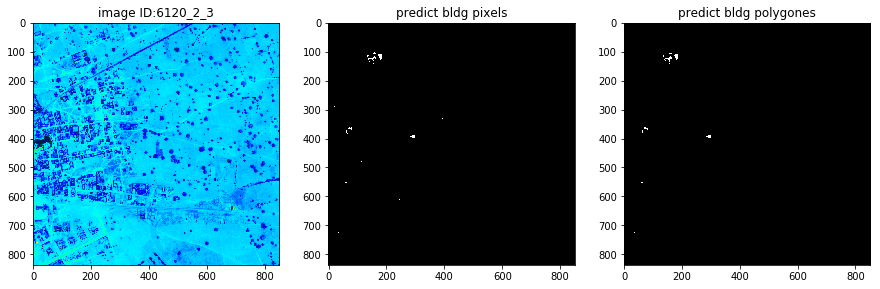

In [36]:
#
#
check_predict()

build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

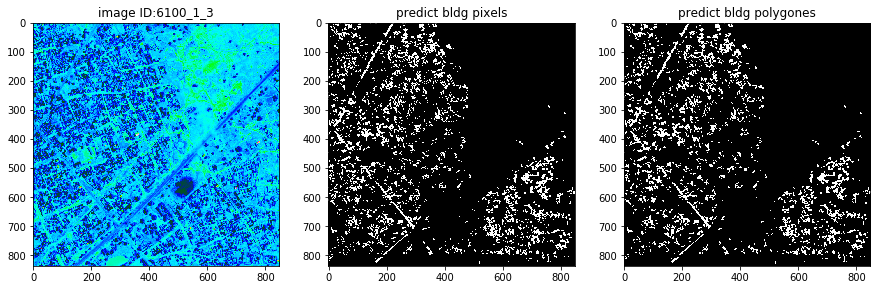

In [40]:
#
#
check_predict1()

In [41]:
# make submission
#
make_submit()

Self-intersection at or near point 593.5333333333333 531
Self-intersection at or near point 844.92814371257487 779.90119760479047
Self-intersection at or near point 182.95081967213116 444.29508196721309


make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
0


Self-intersection at or near point 247.35294117647058 598.35294117647061
Self-intersection at or near point 281.45454545454544 392.72727272727275
Self-intersection at or near point 536 756.125
Self-intersection at or near point 666.75999999999999 504.56
Self-intersection at or near point 785.64525993883797 522.60550458715602
Self-intersection at or near point 318.63636363636363 411.81818181818181
Self-intersection at or near point 729.76095617529882 760.56972111553785
Self-intersection at or near point 823.57142857142856 172.28571428571428
Self-intersection at or near point 823.15916955017303 812.12456747404849
Self-intersection at or near point 758.79999999999995 81.700000000000003
Self-intersection at or near point 820.34285714285716 161.15238095238095
Self-intersection at or near point 846.1351351351351 523.32432432432438
Self-intersection at or near point 631.72500000000002 154.42500000000001
Self-intersection at or near point 553.28451882845184 804.62761506276149
Self-intersection

100


Self-intersection at or near point 352.16268980477224 148.35791757049893
Self-intersection at or near point 568.2814070351759 793.59798994974869
Self-intersection at or near point 328.38028169014086 641.52112676056333
Self-intersection at or near point 800.14754098360652 564.34426229508199
Self-intersection at or near point 209.5 426.5
Self-intersection at or near point 796.39999999999998 360.48571428571427
Self-intersection at or near point 369.82258064516128 99.637096774193552
Self-intersection at or near point 113 462.31578947368422
Ring Self-intersection at or near point 380 319
Self-intersection at or near point 670.3125 567.9375
Self-intersection at or near point 740.73451327433634 570.42477876106193
Self-intersection at or near point 692.0254083484574 0.093163944343617688
Self-intersection at or near point 809 12.777777777777779
Self-intersection at or near point 162.26993865030676 691.65644171779138


200


Self-intersection at or near point 842.47222222222217 62.166666666666664
Self-intersection at or near point 331.46263345195729 400.14234875444839
Self-intersection at or near point 277.95652173913044 115.60869565217391
Self-intersection at or near point 816.10344827586209 565.37931034482756
Self-intersection at or near point 8 164.83333333333334
Self-intersection at or near point 761.9473684210526 143.47368421052633
Self-intersection at or near point 835.10557184750735 609.89149560117301
Self-intersection at or near point 33.724137931034484 816.24137931034488
Self-intersection at or near point 805.96855345911945 600.89937106918239
Self-intersection at or near point 674.23529411764707 804.76470588235293
Self-intersection at or near point 643.5 429.5
Self-intersection at or near point 731.71875 665.65625
Self-intersection at or near point 843.38461538461536 507.69230769230768
Self-intersection at or near point 809.51219512195121 284.78048780487802
Self-intersection at or near point 825.9

300


Self-intersection at or near point 804.49101796407183 778.67065868263478
Self-intersection at or near point 44.475247524752476 830.69306930693074
Self-intersection at or near point 530.20895522388059 785.74626865671644
Self-intersection at or near point 122.48837209302326 565.67441860465112
Self-intersection at or near point 548.94696969696975 212.62878787878788
Self-intersection at or near point 742.3478260869565 129.43478260869566
Self-intersection at or near point 161.36826783114992 365.16739446870452
Self-intersection at or near point 260 0
Self-intersection at or near point 149.3153153153153 602.27027027027032
Self-intersection at or near point 386.08064516129031 273.56451612903226
Self-intersection at or near point 664.43665768194069 813.58490566037733
Self-intersection at or near point 314.4021739130435 258.89130434782606
Self-intersection at or near point 37 17.142857142857142
Self-intersection at or near point 480.58139534883719 228.59302325581396
Self-intersection at or near 

400


Self-intersection at or near point 815.875 485.25
Self-intersection at or near point 809 638
Self-intersection at or near point 204.69803921568626 306.21960784313728
Self-intersection at or near point 222.19148936170214 810.68085106382978
Self-intersection at or near point 509.04587155963304 189.22018348623854
Self-intersection at or near point 16.300000000000001 483.26249999999999
Self-intersection at or near point 732.23076923076928 804.46153846153845
Self-intersection at or near point 779.28571428571433 88
Self-intersection at or near point 824.04761904761904 401.52380952380952
Self-intersection at or near point 838.74285714285713 184.8857142857143
Self-intersection at or near point 243.15789473684211 270.10526315789474
Self-intersection at or near point 479.00719424460431 685.91366906474821
Self-intersection at or near point 690.10380622837374 420.43598615916954
Self-intersection at or near point 835.05727923627683 281.97613365155132
Self-intersection at or near point 669.629629629

500


Self-intersection at or near point 811.41004184100416 723.12133891213387
Self-intersection at or near point 468.95652173913044 828.5978260869565
Self-intersection at or near point 758.23529411764707 695.96078431372553
Self-intersection at or near point 486.76470588235293 647.62352941176471
Self-intersection at or near point 116.35294117647059 406.64705882352939
Self-intersection at or near point 826.19480519480521 51.753246753246756
Self-intersection at or near point 840 204.88888888888889
Self-intersection at or near point 132.68618266978922 774.73770491803282
Self-intersection at or near point 789.16666666666663 340.83333333333331
Self-intersection at or near point 124.95833333333333 335.91666666666669
Ring Self-intersection at or near point 0 569
Self-intersection at or near point 483.66666666666669 625.33333333333337
Self-intersection at or near point 811.88888888888891 772.88888888888891
Self-intersection at or near point 404.64516129032256 637.22580645161293
Self-intersection at 

600


Ring Self-intersection at or near point 569 835
Self-intersection at or near point 819.63636363636363 291.63636363636363
Self-intersection at or near point 699.03284671532845 407.02554744525548
Self-intersection at or near point 77.765243902439025 709.29878048780483
Self-intersection at or near point 691.66101694915255 496.11864406779659
Self-intersection at or near point 341.39024390243901 827.97560975609758
Self-intersection at or near point 836.2388059701492 475.74626865671644
Self-intersection at or near point 796.60000000000002 177.80000000000001
Self-intersection at or near point 414.16129032258067 712.70967741935488
Ring Self-intersection at or near point 100 485
Self-intersection at or near point 87.946808510638292 475.71276595744683
Self-intersection at or near point 620.13043478260875 206.58695652173913
Self-intersection at or near point 584.24770642201838 438.92660550458714
Self-intersection at or near point 795.46719160104988 295.44094488188978
Self-intersection at or near 

700


Self-intersection at or near point 533.17123287671234 6.3082191780821919
Self-intersection at or near point 603.25531914893622 24.829787234042552
Self-intersection at or near point 741.0252707581227 238.72202166064983
Self-intersection at or near point 272.48275862068965 287.34482758620692
Self-intersection at or near point 761.05769230769226 558.57692307692309
Ring Self-intersection at or near point 207 93
Self-intersection at or near point 401.07547169811323 616.79245283018872
Self-intersection at or near point 623.97256097560978 117.9390243902439
Self-intersection at or near point 802.16535433070862 464.3937007874016
Self-intersection at or near point 764.06815761448354 474.92332268370609
Self-intersection at or near point 435.77669902912623 177.02912621359224
Self-intersection at or near point 313.2962962962963 552.25925925925924
Self-intersection at or near point 799 637.46875
Self-intersection at or near point 620.85714285714289 542.05714285714282
Self-intersection at or near poi

800


Self-intersection at or near point 17.05263157894737 143.2982456140351
Self-intersection at or near point 449.11724137931037 97.34482758620689
Self-intersection at or near point 781.43434343434342 158.27272727272728
Self-intersection at or near point 726 548.73684210526312
Self-intersection at or near point 147.14705882352942 5.4117647058823533
Self-intersection at or near point 550.90301003344484 340.33779264214047
Self-intersection at or near point 120.375 181.6875
Self-intersection at or near point 669 467.33333333333331
Self-intersection at or near point 20.600000000000001 439.19999999999999
Self-intersection at or near point 702.84615384615381 831.30769230769226
Self-intersection at or near point 705.17543859649118 824.21929824561403
Self-intersection at or near point 532 254.18181818181819
Self-intersection at or near point 828.40059347181011 18.643916913946587
Self-intersection at or near point 818.07614213197974 184.46700507614213
Self-intersection at or near point 824.59349593

900


Self-intersection at or near point 844.81967213114751 164.85245901639345
Self-intersection at or near point 773.42857142857144 737.17857142857144
Self-intersection at or near point 819.18548387096769 656.63709677419354
Self-intersection at or near point 835.11864406779659 449.05084745762713
Ring Self-intersection at or near point 838 159
Self-intersection at or near point 812.07453416149065 28.062111801242235
Self-intersection at or near point 845.89361702127655 270.21276595744683
Self-intersection at or near point 581.96703296703299 342.1098901098901
Self-intersection at or near point 816.21951219512198 371.07317073170731
Self-intersection at or near point 842.95652173913038 174.91304347826087
Self-intersection at or near point 847.32183908045977 240.31034482758622
Self-intersection at or near point 344.01190476190476 821.04761904761904
Self-intersection at or near point 844.8478260869565 615.08695652173913
Self-intersection at or near point 822.98031496062993 824.17716535433067
Self-

1000


Self-intersection at or near point 298.95209580838321 276.16766467065867
Self-intersection at or near point 792.32432432432438 137.05405405405406
Self-intersection at or near point 787 160
Self-intersection at or near point 513.46242774566474 27.959537572254334
Self-intersection at or near point 736.06106870229007 276.30916030534354
Self-intersection at or near point 830.44155844155841 208.09090909090909
Self-intersection at or near point 825.85074626865674 367.9957356076759
Self-intersection at or near point 843.82089552238801 171.16417910447763
Self-intersection at or near point 791.06896551724139 104.82758620689656
Self-intersection at or near point 643 1
Self-intersection at or near point 788.0061349693251 84.907975460122699
Self-intersection at or near point 584.04444444444448 635.08888888888885
Self-intersection at or near point 813.30188679245282 696.11320754716985
Self-intersection at or near point 812.59420289855075 60.94202898550725
Self-intersection at or near point 690.0909

1100


Self-intersection at or near point 709.03305785123962 246.55371900826447
Self-intersection at or near point 614.64814814814815 6.2407407407407405
Self-intersection at or near point 656.15789473684208 786.37894736842111
Self-intersection at or near point 137.71717171717171 397.59595959595958
Self-intersection at or near point 656 359.54545454545456
Self-intersection at or near point 183.40000000000001 28.600000000000001
Self-intersection at or near point 809.02030456852788 789.79695431472078
Self-intersection at or near point 727.60000000000002 754.44000000000005
Self-intersection at or near point 717.82967032967031 89.296703296703299
Self-intersection at or near point 845.70151636073422 126.13567438148444
Self-intersection at or near point 646.76963350785343 736.74869109947645
Self-intersection at or near point 25 611.71875
Self-intersection at or near point 224 79
Self-intersection at or near point 804.36363636363637 472.72727272727275
Self-intersection at or near point 620.5185185185

1200


Self-intersection at or near point 612.79999999999995 347.60000000000002
Self-intersection at or near point 646.54491017964074 784.07784431137725
Self-intersection at or near point 101.85714285714286 778
Self-intersection at or near point 584.22821576763488 682.04149377593365
Self-intersection at or near point 575.92338709677415 700.78629032258061
Self-intersection at or near point 650.24481865284974 435.84844559585491
Self-intersection at or near point 743.48201438848923 259.136690647482
Self-intersection at or near point 743.89655172413791 399.89655172413791
Self-intersection at or near point 839.90625 230.0625
Self-intersection at or near point 801.74193548387098 186.54838709677421
Self-intersection at or near point 847.78769497400344 630.33362218370883
Self-intersection at or near point 764.32989690721649 802.52577319587624
Self-intersection at or near point 754.26315789473688 784.47368421052636
Ring Self-intersection at or near point 12 28
Self-intersection at or near point 844.67

1300


Self-intersection at or near point 508.17226890756302 758.23949579831935
Self-intersection at or near point 159 485
Ring Self-intersection at or near point 192 735
Self-intersection at or near point 751.5333333333333 740.5333333333333
Self-intersection at or near point 798.47058823529414 483.52941176470586
Self-intersection at or near point 600.05479452054794 804.21917808219177
Self-intersection at or near point 795.32203389830511 289.96610169491527
Self-intersection at or near point 785.86516853932585 629.33707865168537
Self-intersection at or near point 372.97826086956519 579.78260869565213
Self-intersection at or near point 734.66666666666663 623.08333333333337
Self-intersection at or near point 792.46153846153845 423.46153846153845
Self-intersection at or near point 29.057142857142857 204.08571428571429
Self-intersection at or near point 64.839237057220714 120.71389645776567
Self-intersection at or near point 140.11682242990653 125.16355140186916
Self-intersection at or near point 

1400


Self-intersection at or near point 806.55555555555554 208.5679012345679
Self-intersection at or near point 846.56756756756761 253
Self-intersection at or near point 739.19480519480521 110.57142857142857
Self-intersection at or near point 669.12 80.439999999999998
Self-intersection at or near point 300 110.58823529411765
Self-intersection at or near point 181.08108108108109 435.48648648648651
Self-intersection at or near point 476.03703703703701 32.530864197530867
Self-intersection at or near point 21 640
Ring Self-intersection at or near point 161 804
Self-intersection at or near point 77 836
Self-intersection at or near point 719.01219512195121 741.13414634146341
Self-intersection at or near point 569.74834437086088 825.50993377483439
Self-intersection at or near point 811.08304498269899 727.55363321799302
Self-intersection at or near point 362.97196261682245 602.56074766355141
Self-intersection at or near point 799.72727272727275 371
Self-intersection at or near point 813.05607476635

1500


Self-intersection at or near point 536.17142857142858 249.25714285714287
Self-intersection at or near point 831.546875 800
Self-intersection at or near point 649.80471380471386 117.22895622895624
Self-intersection at or near point 537.39999999999998 693.93333333333328
Self-intersection at or near point 724.97368421052636 668.65789473684208
Self-intersection at or near point 782.32432432432438 566.43243243243239
Self-intersection at or near point 761.89473684210532 827.84210526315792
Self-intersection at or near point 571.14953271028037 519.59345794392527
Self-intersection at or near point 711.75738396624467 483.86075949367091
Self-intersection at or near point 304.96984924623115 640.0251256281407
Self-intersection at or near point 748.74061433447093 233.02389078498294
Self-intersection at or near point 757.76470588235293 269.41176470588238
Self-intersection at or near point 835.23711340206182 817.84536082474222
Self-intersection at or near point 490.54545454545456 260.63636363636363
Se

1600


Self-intersection at or near point 839.18584070796464 297.05309734513276
Self-intersection at or near point 661.09404388714734 410.93103448275861
Self-intersection at or near point 608.23809523809518 148.66666666666666
Self-intersection at or near point 536.56692913385825 203.55905511811022
Self-intersection at or near point 807.45000000000005 761.75
Self-intersection at or near point 565.48453608247428 768.1649484536083
Self-intersection at or near point 820.4666666666667 215.59999999999999
Self-intersection at or near point 713.45652173913038 641.52173913043475
Self-intersection at or near point 819.47500000000002 520.29999999999995
Self-intersection at or near point 598.92592592592598 358.2962962962963
Self-intersection at or near point 480.59558823529414 70.933823529411768
Self-intersection at or near point 309.625 136.375
Self-intersection at or near point 646.04255319148933 81.148936170212764
Self-intersection at or near point 575.84210526315792 197.15789473684211
Self-intersecti

1700


Self-intersection at or near point 544.55944055944053 19.027972027972027
Self-intersection at or near point 166.62650602409639 809.84337349397595
Self-intersection at or near point 691.46511627906978 649.27906976744191
Ring Self-intersection at or near point 667 109
Self-intersection at or near point 144.59999999999999 36.799999999999997
Self-intersection at or near point 477.80000000000001 36.799999999999997
Self-intersection at or near point 834.19444444444446 674.19444444444446
Self-intersection at or near point 796.75975975975973 444.18318318318319
Self-intersection at or near point 702.48292682926831 297.29756097560977
Self-intersection at or near point 397.18918918918916 143.45945945945945
Self-intersection at or near point 488.43763213530656 209.61099365750528
Self-intersection at or near point 843.43451143451148 39.844074844074846
Self-intersection at or near point 120.05134474327629 208.85330073349633
Self-intersection at or near point 756.5532879818594 114.94104308390023
Self

1800


Self-intersection at or near point 803.66666666666663 422.42857142857144
Self-intersection at or near point 5.4240000000000004 196.84800000000001
Self-intersection at or near point 655 70.666666666666671
Self-intersection at or near point 701.99143206854342 461.76866585067319
Self-intersection at or near point 813.04615384615386 315.94358974358977
Self-intersection at or near point 767.29608938547483 751.79329608938542
Self-intersection at or near point 793 788
Self-intersection at or near point 16.699029126213592 344.58252427184465
Self-intersection at or near point 150.09756097560975 536.65853658536582
Self-intersection at or near point 13.159574468085106 267.64893617021278
Self-intersection at or near point 16.508021390374331 689.1604278074866
Self-intersection at or near point 468.95419847328242 145.10687022900763
Self-intersection at or near point 821.00898203592817 821.85628742514973
Self-intersection at or near point 844.66666666666663 129
Self-intersection at or near point 177.

1900


Self-intersection at or near point 485.08524590163933 135.07868852459018
Self-intersection at or near point 433 164.13333333333333
Ring Self-intersection at or near point 158 222
Self-intersection at or near point 387.54545454545456 107.45454545454545
Self-intersection at or near point 341.30201342281879 207.92617449664431
Self-intersection at or near point 819.97326203208559 271.88770053475935
Self-intersection at or near point 420.59420289855075 758.1159420289855
Self-intersection at or near point 344.89839572192511 403.11229946524065
Self-intersection at or near point 703.58333333333337 515.16666666666663
Self-intersection at or near point 304.12316715542522 789.97653958944284
Self-intersection at or near point 577.71428571428567 636.71428571428567
Self-intersection at or near point 743.75 42.375
Self-intersection at or near point 722.29411764705878 195.3475935828877
Self-intersection at or near point 768.81553398058247 140.08737864077671
Self-intersection at or near point 846.56637

2000


Self-intersection at or near point 808.86792452830184 153.75471698113208
Self-intersection at or near point 649.61538461538464 291.61538461538464
Self-intersection at or near point 831.39925373134326 96.679104477611943
Self-intersection at or near point 845.24170616113747 170.29383886255926
Self-intersection at or near point 605.49295774647885 122.29577464788733
Self-intersection at or near point 845.74770642201838 506.79816513761466
Self-intersection at or near point 722.44827586206895 123.40229885057471
Self-intersection at or near point 841.88108108108111 346.00540540540538
Self-intersection at or near point 827.29268292682923 582.09756097560978
Self-intersection at or near point 769.81395348837214 214.04651162790697
Self-intersection at or near point 358.19999999999999 801.60000000000002
Self-intersection at or near point 579.1584158415842 194.70297029702971
Self-intersection at or near point 807.3384615384615 421.40769230769229
Self-intersection at or near point 692.16300940438873

2100


Self-intersection at or near point 825.43396226415098 25.90566037735849
Self-intersection at or near point 775.95412844036696 698.25993883792046
Self-intersection at or near point 767.09855072463768 801.54202898550727
Self-intersection at or near point 843.92116182572613 298.26970954356847
Self-intersection at or near point 608.16766467065872 69.377245508982043
Self-intersection at or near point 843.44444444444446 5.1851851851851851
Self-intersection at or near point 769.46153846153845 424.61538461538464
Self-intersection at or near point 484.40466926070042 786.79571984435802
Self-intersection at or near point 843.39130434782612 36.113712374581937
Self-intersection at or near point 658.59776536312847 56.089385474860336
Self-intersection at or near point 444.02054794520546 383.17808219178085
Self-intersection at or near point 701.13698630136992 493.84931506849313
Self-intersection at or near point 796.92857142857144 181.5612244897959
Self-intersection at or near point 844.53658536585363

2200


Self-intersection at or near point 811.43165467625897 667.39568345323744
Self-intersection at or near point 812.4367176634214 285.18636995827541
Self-intersection at or near point 777.60000000000002 589
Self-intersection at or near point 833.42744479495263 776.31230283911668
Self-intersection at or near point 823.92476489028218 90.319749216300934
Self-intersection at or near point 778.42857142857144 316.14285714285717
Self-intersection at or near point 830.93913043478256 249.06086956521739
Self-intersection at or near point 358.10526315789474 242.84210526315789
Ring Self-intersection at or near point 178 1
Self-intersection at or near point 822.39473684210532 268.92105263157896
Self-intersection at or near point 792.39047619047619 791.37142857142862
Self-intersection at or near point 566.27388535031844 763.80891719745227
Self-intersection at or near point 691.45381526104416 744.01606425702812
Self-intersection at or near point 674.82866043613706 202.30529595015577
Self-intersection at 

2300


Self-intersection at or near point 706 63.299999999999997
Self-intersection at or near point 588.089156626506 563.04216867469881
Self-intersection at or near point 811.99426934097426 770.07449856733524
Self-intersection at or near point 701.88 325.51999999999998
Self-intersection at or near point 3 724.5
Self-intersection at or near point 13.753246753246753 185.06493506493507
Self-intersection at or near point 792.55721393034821 81.71641791044776
Self-intersection at or near point 763.61454545454546 706.67636363636359
Self-intersection at or near point 429.97997496871091 638.9249061326658
Self-intersection at or near point 137 699.27777777777783
Self-intersection at or near point 651.34730538922156 823.57485029940119
Self-intersection at or near point 844.29032258064512 87.709677419354833
Ring Self-intersection at or near point 325 768
Self-intersection at or near point 574.57303370786519 789.55056179775283
Self-intersection at or near point 78.124137931034483 612.27931034482754
Self-i

2400


Self-intersection at or near point 521.8039215686274 831.8039215686274
Self-intersection at or near point 834.04999999999995 291.94999999999999
Self-intersection at or near point 598.57198443579762 550.76653696498056
Self-intersection at or near point 843.09708737864082 790.00970873786412
Self-intersection at or near point 842.57142857142856 328.14285714285717
Self-intersection at or near point 156.48514851485149 504.04950495049508
Self-intersection at or near point 821.6615384615385 791.10769230769233
Self-intersection at or near point 839.49206349206349 619.69312169312173
Self-intersection at or near point 610.11111111111109 807.11111111111109
Self-intersection at or near point 603.59753954305802 175.31634446397189
Self-intersection at or near point 805 656
Self-intersection at or near point 502.6233766233766 171.2987012987013
Self-intersection at or near point 492.12903225806451 310.51612903225805
Self-intersection at or near point 492.67567567567568 276.41621621621624
Self-intersec

2500


Self-intersection at or near point 771.80645161290317 817.41935483870964
Self-intersection at or near point 179.07142857142858 354.92857142857144
Self-intersection at or near point 780.81967213114751 349.49180327868851
Self-intersection at or near point 830.82539682539687 709.04761904761904
Self-intersection at or near point 231.35849056603774 16.047169811320757
Self-intersection at or near point 678.33663366336634 479.37623762376239
Self-intersection at or near point 799 554.16216216216219
Self-intersection at or near point 274.51612903225805 391.51612903225805
Self-intersection at or near point 788.40495867768595 553.05785123966939
Self-intersection at or near point 768.11940298507466 63.537313432835823
Self-intersection at or near point 560.64705882352939 113.58823529411765
Self-intersection at or near point 729.44295302013427 498.51677852348996
Self-intersection at or near point 636.31818181818187 107.83116883116884
Self-intersection at or near point 675.16666666666663 47.5
Ring Se

2600


Self-intersection at or near point 388.92000000000002 409.36000000000001
Self-intersection at or near point 161.73248407643311 643.40764331210187
Self-intersection at or near point 768.36254980079684 674.39442231075702
Self-intersection at or near point 34.54054054054054 685.72972972972968
Self-intersection at or near point 797 363.76470588235293
Self-intersection at or near point 306.61061946902657 818.67256637168146
Self-intersection at or near point 582.34210526315792 94.065789473684205
Self-intersection at or near point 847.04999999999995 246.67857142857142
Self-intersection at or near point 505.49206349206349 353.11111111111109
Self-intersection at or near point 563.30578512396698 524.75206611570252
Self-intersection at or near point 463.03960396039605 283.7227722772277
Self-intersection at or near point 586.757281553398 572.12621359223306
Self-intersection at or near point 92.791666666666671 515.80555555555554
Self-intersection at or near point 709.26490066225165 149.185430463576

2700


Self-intersection at or near point 646.37931034482756 714.68965517241384
Self-intersection at or near point 221.55234657039711 289.65342960288808
Self-intersection at or near point 647.31428571428569 703.25714285714287
Self-intersection at or near point 238.09090909090909 189.45454545454547
Self-intersection at or near point 176.72727272727272 500.18181818181819
Self-intersection at or near point 339.78610603290679 632.76965265082265
Self-intersection at or near point 746.48543689320388 196.66019417475729
Self-intersection at or near point 827 338.05263157894734
Self-intersection at or near point 586.24806201550382 399.06976744186045
Self-intersection at or near point 141.97916666666666 2.0375000000000001
Self-intersection at or near point 30.039999999999999 374.48000000000002
Self-intersection at or near point 61.81818181818182 456
Self-intersection at or near point 153.71428571428572 414.71428571428572
Self-intersection at or near point 209.4406779661017 469.66949152542372
Self-inter

2800


Self-intersection at or near point 751.17241379310349 175.06896551724137
Self-intersection at or near point 847 208
Self-intersection at or near point 779.05660377358492 361.09433962264148
Self-intersection at or near point 684.39767441860465 649.49302325581391
Self-intersection at or near point 297.69054441260744 19.034383954154727
Self-intersection at or near point 60.4141592920354 425.69734513274335
Self-intersection at or near point 98.441314553990608 449.01408450704224
Self-intersection at or near point 688.03587443946185 345.66367713004485
Self-intersection at or near point 632.60000000000002 551.20000000000005
Self-intersection at or near point 833.21052631578948 802.66315789473686
Self-intersection at or near point 696.43585237258344 654.03514938488581
Self-intersection at or near point 618.5151515151515 410.4848484848485
Self-intersection at or near point 841.82142857142856 78.476190476190482
Self-intersection at or near point 259.69230769230768 122
Self-intersection at or nea

2900


Self-intersection at or near point 660.43283582089555 542.6567164179105
Self-intersection at or near point 839.0432432432433 107.08108108108108
Self-intersection at or near point 726.13970588235293 759.89705882352939
Self-intersection at or near point 568.85567010309273 84.979381443298962
Self-intersection at or near point 639.42857142857144 627.28571428571433
Self-intersection at or near point 371.09604519774012 833.18644067796606
Self-intersection at or near point 504.35000000000002 553.35000000000002
Self-intersection at or near point 403 275.07407407407408
Self-intersection at or near point 835.75 647.25
Self-intersection at or near point 467.64705882352939 675.35294117647061
Self-intersection at or near point 831.27547169811317 525.32830188679247
Self-intersection at or near point 612 800
Self-intersection at or near point 846 182
Self-intersection at or near point 639.95419847328242 497.96183206106872
Self-intersection at or near point 827.42222222222222 363.80000000000001
Self-i

3000


Self-intersection at or near point 678.26197183098589 96.149295774647882
Self-intersection at or near point 551.21052631578948 195
Self-intersection at or near point 2 193
Self-intersection at or near point 344.25316455696202 159.54430379746836
Self-intersection at or near point 602.88286334056397 576.06507592190894
Self-intersection at or near point 761.23668639053255 611.10059171597629
Self-intersection at or near point 836.81746031746036 458.82539682539681
Self-intersection at or near point 760.39130434782612 440.82608695652175
Self-intersection at or near point 530.93258426966293 477.88764044943821
Self-intersection at or near point 817.66666666666663 14
Self-intersection at or near point 578.88888888888891 306.33333333333331
Self-intersection at or near point 507 0.30434782608695654
Self-intersection at or near point 744.83333333333337 751.08333333333337
Self-intersection at or near point 324.53374233128835 642.24539877300617
Self-intersection at or near point 592.22435897435901 3

3100


Self-intersection at or near point 821.36263736263732 273.54945054945057
Self-intersection at or near point 798.71375464684013 246.58364312267659
Self-intersection at or near point 515.05882352941171 2.1568627450980391
Self-intersection at or near point 412 807.5
Self-intersection at or near point 839.4545454545455 675.77272727272725
Self-intersection at or near point 803.69955156950675 84.349775784753362
Self-intersection at or near point 202.03225806451613 826.0322580645161
Self-intersection at or near point 769 549.90909090909088
Ring Self-intersection at or near point 834 384
Self-intersection at or near point 758.91780821917803 97.273972602739732
Self-intersection at or near point 348 208.33333333333334
Self-intersection at or near point 702.25 36.5
Self-intersection at or near point 614.84615384615381 803.41025641025647
Self-intersection at or near point 506.65306122448982 824.81632653061229
Self-intersection at or near point 267.08333333333331 213.54166666666666
Self-intersectio

3200


Self-intersection at or near point 833.17272727272723 726.24545454545455
Self-intersection at or near point 799.0976744186047 421.1720930232558
Self-intersection at or near point 831.13793103448279 500.13793103448273
Self-intersection at or near point 723.33333333333337 783.77777777777783
Self-intersection at or near point 389.54135338345867 366.3233082706767
Self-intersection at or near point 434.22580645161293 775.16129032258061
Self-intersection at or near point 375.09859154929575 685.77464788732391
Self-intersection at or near point 680.24719101123594 700.49438202247188
Self-intersection at or near point 108.06968641114983 769.2439024390244
Self-intersection at or near point 383.8354430379747 310.40506329113924
Self-intersection at or near point 327.24916943521595 263.21926910299004
Self-intersection at or near point 675.46534653465346 567.86138613861385
Self-intersection at or near point 241.13872832369941 74.537572254335259
Self-intersection at or near point 779.5602836879433 55.

3300


Self-intersection at or near point 549.16883116883116 717.39393939393938
Self-intersection at or near point 397.84549356223175 141.12017167381975
Self-intersection at or near point 844.74074074074076 327.18518518518516
Self-intersection at or near point 46.137724550898206 817.82035928143716
Self-intersection at or near point 489.55102040816325 729.55102040816325
Self-intersection at or near point 494.80000000000001 512.32000000000005
Self-intersection at or near point 358.25 666.75
Self-intersection at or near point 747.90909090909088 132.68181818181819
Self-intersection at or near point 561.04347826086962 616.97826086956525
Self-intersection at or near point 350.4493927125506 787.51417004048585
Self-intersection at or near point 765.72093023255809 774.51162790697674
Self-intersection at or near point 642.93150684931504 527.34246575342468
Self-intersection at or near point 771.88888888888891 85.148148148148152
Self-intersection at or near point 846.67521367521363 348.90598290598291
Sel

3400


Self-intersection at or near point 314.18367346938777 581.89795918367349
Self-intersection at or near point 527.24137931034488 558.58620689655174
Self-intersection at or near point 664.25339366515834 214.85972850678732
Self-intersection at or near point 669.11111111111109 355.88888888888891
Self-intersection at or near point 805.31645569620252 92.822784810126578
Self-intersection at or near point 544.32142857142856 432.53571428571428
Self-intersection at or near point 836.79310344827582 528.94827586206895
Self-intersection at or near point 836.53846153846155 53.92307692307692
Self-intersection at or near point 539.61290322580646 402.32258064516128
Self-intersection at or near point 830.45945945945948 733.02702702702697
Self-intersection at or near point 318.32394366197184 493.3943661971831
Self-intersection at or near point 654.39393939393938 335.09090909090907
Self-intersection at or near point 428.66094420600859 803.75536480686696
Self-intersection at or near point 547.67521367521363

3500


Self-intersection at or near point 115 400
Self-intersection at or near point 484.17391304347825 283.73913043478262
Self-intersection at or near point 776.26315789473688 576.26315789473688
Self-intersection at or near point 802.29636048526868 77.263431542461007
Self-intersection at or near point 563.2844827586207 744.20689655172418
Self-intersection at or near point 691.0980392156863 511.60784313725492
Self-intersection at or near point 247.14285714285714 510.57142857142856
Ring Self-intersection at or near point 267 177
Self-intersection at or near point 588.35820895522386 124.6268656716418
Self-intersection at or near point 480 294.83333333333331
Ring Self-intersection at or near point 243 426
Self-intersection at or near point 273.05504587155963 628.9174311926605
Self-intersection at or near point 683.85714285714289 237.57142857142858
Self-intersection at or near point 560.46153846153845 714.38461538461536
Self-intersection at or near point 471.16666666666669 206.33333333333334
Self

3600


Self-intersection at or near point 625 349
Self-intersection at or near point 720.73568281938321 325.85022026431716
Self-intersection at or near point 459.4830508474576 358.60169491525426
Self-intersection at or near point 617 160
Self-intersection at or near point 750.90322580645159 654.06451612903231
Self-intersection at or near point 784.66042154566742 440.25292740046837
Self-intersection at or near point 213.22222222222223 332.5
Self-intersection at or near point 703.82733812949641 627.15107913669067
Self-intersection at or near point 685.26586102719034 458.33836858006043
Self-intersection at or near point 809.81818181818187 435.09090909090907
Self-intersection at or near point 849 269
Self-intersection at or near point 835.56050955414014 705.53503184713372
Self-intersection at or near point 316.51999999999998 144.19200000000001
Self-intersection at or near point 394.73684210526318 575.36842105263156
Self-intersection at or near point 817.94308943089436 46.544715447154474
Self-inte

3700


Self-intersection at or near point 656.43478260869563 221.04347826086956
Self-intersection at or near point 472.07692307692309 595.92307692307691
Self-intersection at or near point 195.08641975308643 620.93827160493822
Self-intersection at or near point 686.71929824561403 340.85964912280701
Self-intersection at or near point 805.28985507246375 236.81884057971016
Self-intersection at or near point 145.2775119617225 623.61722488038276
Self-intersection at or near point 350.92473118279571 127.54838709677419
Self-intersection at or near point 815.3121387283237 231.82658959537574
Self-intersection at or near point 705.69329529243942 800.73609129814554
Self-intersection at or near point 58.4375 580.734375
Self-intersection at or near point 795.42338709677415 792.41935483870964
Self-intersection at or near point 642.83333333333337 3
Self-intersection at or near point 825.81609195402302 624.18965517241384
Self-intersection at or near point 185.22058823529412 94.029411764705884
Self-intersectio

3800


Self-intersection at or near point 845.19791666666663 782.71875
Self-intersection at or near point 824.79757085020242 717.65789473684208
Self-intersection at or near point 639.15887850467288 277.74766355140184
Self-intersection at or near point 462.046875 526.8125
Self-intersection at or near point 809.53846153846155 253.15384615384616
Self-intersection at or near point 837.73749999999995 528.70000000000005
Self-intersection at or near point 808.91304347826087 479.80869565217392
Self-intersection at or near point 642.40740740740739 287.92592592592592
Self-intersection at or near point 518.2389380530974 271.94690265486724
Ring Self-intersection at or near point 733 320
Self-intersection at or near point 714.11538461538464 634.69230769230774
Ring Self-intersection at or near point 834 667
Self-intersection at or near point 604 1
Self-intersection at or near point 726.95833333333337 146.99583333333334


3900


Self-intersection at or near point 743.13043478260875 660.08695652173913
Self-intersection at or near point 846.67041198501875 436.62921348314609
Self-intersection at or near point 801.41999999999996 577.01999999999998
Self-intersection at or near point 788.21052631578948 202.10526315789474
Self-intersection at or near point 836.92857142857144 775.75
Self-intersection at or near point 830.82089552238801 200.67164179104478
Self-intersection at or near point 820 164.44
Self-intersection at or near point 648.92592592592598 790.40740740740739
Self-intersection at or near point 782 297.71428571428572
Self-intersection at or near point 488.80769230769232 801.30769230769226
Self-intersection at or near point 845.26198083067095 536.63258785942492
Self-intersection at or near point 555.31455399061031 124.7981220657277
Self-intersection at or near point 365.92307692307691 664.84615384615381
Self-intersection at or near point 628.53072625698326 446.66480446927375
Self-intersection at or near poin

4000


Self-intersection at or near point 615.3221757322176 588.61924686192469
Self-intersection at or near point 310.44170403587447 305.77354260089686
Self-intersection at or near point 675.12854442344042 266.17202268431004
Self-intersection at or near point 510.83333333333331 526
Self-intersection at or near point 561.02222222222224 321.15555555555557
Self-intersection at or near point 767.02870813397124 337.51196172248802
Self-intersection at or near point 718.06185567010311 546.9432989690722
Self-intersection at or near point 742.91666666666663 478.02380952380952
Self-intersection at or near point 764.1232876712329 601.7397260273973
Self-intersection at or near point 441.66272189349115 76.786982248520715
Self-intersection at or near point 292.97014925373134 832.73134328358208
Self-intersection at or near point 544.6686567164179 4.6776119402985072
Self-intersection at or near point 299.25352112676057 401.40845070422534
Self-intersection at or near point 157.28571428571428 388.5714285714285

4100


Self-intersection at or near point 115.05555555555556 772.96296296296293
Self-intersection at or near point 735.24590163934431 243.10928961748633
Self-intersection at or near point 585.64227642276421 220.7479674796748
Self-intersection at or near point 715 0
Self-intersection at or near point 110.9047619047619 462.90476190476193
Self-intersection at or near point 779.79472140762459 69.592375366568916
Self-intersection at or near point 832.60869565217388 536.56521739130437
Ring Self-intersection at or near point 319 364
Self-intersection at or near point 769.75150300601206 300.83867735470943
Self-intersection at or near point 376.86363636363637 679.86363636363637
Self-intersection at or near point 671.26086956521738 485.33043478260868
Self-intersection at or near point 445.04046242774564 601.06358381502889
Self-intersection at or near point 65.784135240572169 750.52405721716514
Self-intersection at or near point 767.08333333333337 56
Self-intersection at or near point 618.0980392156863 

4200


Self-intersection at or near point 528.23529411764707 832.41176470588232
Self-intersection at or near point 781 65.5
Self-intersection at or near point 302.96728971962619 804.6121495327103
Self-intersection at or near point 823.52494577006507 473.77440347071581
Ring Self-intersection at or near point 847 257
Self-intersection at or near point 676.79775280898878 250.70786516853931
Self-intersection at or near point 518 161.78947368421052
Self-intersection at or near point 684.25 129
Self-intersection at or near point 703.39743589743591 365.17948717948718
Self-intersection at or near point 655.25925925925924 368.88888888888891
Self-intersection at or near point 560.59463487332334 745.96870342771979
Self-intersection at or near point 827.16176470588232 117.48529411764706
Self-intersection at or near point 652 673.79999999999995
Self-intersection at or near point 299.03271028037381 28.752336448598129
Self-intersection at or near point 326.13157894736844 580.52631578947364
Self-intersection

    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0061055575672065 -0.00728821...
1  6120_2_4          2  MULTIPOLYGON (((0.0073721359987014 -0.00790458...
2  6120_2_4          3  MULTIPOLYGON (((0.0091691618074892 -0.00328726...
3  6120_2_4          4  MULTIPOLYGON (((0.0091691618074892 -0.00082181...
4  6120_2_4          5  MULTIPOLYGON (((0.0091366854374508 -0.00510391...


In [28]:
# N_Cls = 10
N_Cls = 1
inDir = '/home/ubuntu/data/dstl/data'
topDir = '/home/ubuntu/data/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(topDir + '/subm/sample_submission.csv')
ISZ = 160
smooth = 1e-12

In [29]:
DF = DF.loc[(DF['ClassType'] == 1)] # | (DF['ClassType'] == 2)]
print len(DF)
print len(GS)
print len(SB)

25
450
4290


In [30]:
stick_all_train()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0


In [31]:
make_val()

let's pick some samples for validation
(82, 8, 160, 160) (82, 1, 160, 160) 1.0 -1.0 1.0 0.0


In [61]:
def train_net():
    print "start train net"
    x_val, y_val = np.load(inDir + '/x_tmp_%d.npy' % N_Cls), np.load(inDir +'/y_tmp_%d.npy' % N_Cls)
   
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)
    print np.ndim(x_trn)
    print np.ndim(y_trn)
    model = get_unet()

    model.load_weights(topDir + '/weights/buildings_unet_10_jk0.0780')
#    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
#    model.load_weights(topDir + '/weights/baseline.w')
    model_checkpoint = ModelCheckpoint(topDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(200):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=10, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights(topDir + '/weights/buildings_unet_10_jk%.4f' % score)

    return model

In [ ]:
model = train_net()

start train net
(224, 8, 160, 160) (224, 1, 160, 160) 1.0 -1.0 1.0 0.0
4
4
build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

Train on 224 samples, validate on 82 samples
Epoch 1/10
224/224 [==============================] - 22s - loss: 0.3730 - jaccard_coef: 0.6141 - jaccard_coef_int: 0.6141 - acc: 0.8264 - val_loss: 0.3369 - val_jaccard_coef: 0.5938 - val_jaccard_coef_int: 0.5938 - val_acc: 0.8494
Epoch 2/10
192/224 [========================>.....] - ETA: 2s - loss: 0.3426 - jaccard_coef: 0.6040 - jaccard_coef_int: 0.6040 - acc: 0.8465

In [47]:
score, trs = calc_jacc(model)

(82, 1, 160, 160) (82, 1, 160, 160)
0 0.777859124982 0.3


In [48]:
predict_test(model, trs)

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0


In [49]:
def make_submit():
    print "make submission file"
#    df = pd.read_csv(os.path.join(topDir + '/subm/BASELINE__empty_with_true_train.csv'))
    df = pd.read_csv(os.path.join(topDir + '/subm/buildings_base_v1.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1
        if kls == 0: #  class 0 is buildings
            msk = np.load(topDir + '/msk/10_%s.npy' % id)[kls]
            pred_polygons = mask_to_polygons(msk)
            x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
            y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]
            x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

            scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,origin=(0, 0, 0))
            df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv(topDir + '/subm/buildings_29_06_v2.csv', index=False)

In [50]:
make_submit()

make submission file


Self-intersection at or near point 326.69999999999999 597


    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0061055575672065 -0.00728821...
1  6120_2_4          2  MULTIPOLYGON (((0.0073721359987014 -0.00790458...
2  6120_2_4          3  MULTIPOLYGON (((0.0091691618074892 -0.00328726...
3  6120_2_4          4  MULTIPOLYGON (((0.0091691618074892 -0.00082181...
4  6120_2_4          5  MULTIPOLYGON (((0.0091366854374508 -0.00510391...
0


Self-intersection at or near point 842.06324110671937 691.92885375494075
Self-intersection at or near point 795.11111111111109 11.666666666666668
Self-intersection at or near point 733.33333333333337 95.571428571428569
Self-intersection at or near point 824.64999999999998 731.70000000000005
Self-intersection at or near point 640.72137404580155 725.41221374045801
Self-intersection at or near point 344.55080213903744 23.486631016042782
Self-intersection at or near point 224.47368421052633 319.10526315789474
Self-intersection at or near point 612.60869565217388 640
Self-intersection at or near point 110.8252427184466 503.73786407766988
Self-intersection at or near point 845.80455740578441 115.14110429447852
Self-intersection at or near point 750.68085106382978 389.57446808510639
Self-intersection at or near point 478.51999999999998 622.63
Ring Self-intersection at or near point 42 743
Self-intersection at or near point 267.06214689265539 563.12994350282486


100


Self-intersection at or near point 282.09565217391304 445.46086956521737
Self-intersection at or near point 635.70588235294122 442.47058823529414
Self-intersection at or near point 836.73333333333335 564.39999999999998
Self-intersection at or near point 811.38095238095241 414.38095238095241
Self-intersection at or near point 766.16326530612241 571.44897959183675
Self-intersection at or near point 595.56716417910445 646.6567164179105


200


Self-intersection at or near point 652.2268041237113 387.95876288659792
Self-intersection at or near point 807 543.72727272727275
Self-intersection at or near point 639.59615384615381 158.01923076923077
Self-intersection at or near point 672.75471698113211 551.4905660377359
Self-intersection at or near point 618.01171875 282.18359375
Self-intersection at or near point 814.91891891891896 217.37837837837839
Self-intersection at or near point 634.51401869158883 35.383177570093459
Self-intersection at or near point 804.2465753424658 664.57534246575347
Self-intersection at or near point 677.53488372093022 47.093023255813954
Self-intersection at or near point 397 711.33333333333337
Self-intersection at or near point 159.8125 149.2890625
Self-intersection at or near point 326.28767123287673 818.10958904109589
Self-intersection at or near point 537.45161290322585 27


300


Self-intersection at or near point 621.18975903614455 259.21084337349396
Self-intersection at or near point 746.93548387096769 34.225806451612904
Self-intersection at or near point 161.75 158.35714285714286
Self-intersection at or near point 777.94444444444446 35.777777777777779
Self-intersection at or near point 150.28571428571428 435.68571428571431
Self-intersection at or near point 269.2340425531915 319.65957446808511
Self-intersection at or near point 61 484.21052631578948
Self-intersection at or near point 800.87096774193549 180.29032258064515
Self-intersection at or near point 232.57894736842104 833.42105263157896


400


Self-intersection at or near point 828.54482758620691 549.08275862068967
Self-intersection at or near point 816.77981651376149 780.80733944954125
Self-intersection at or near point 665.31818181818187 570.0454545454545
Self-intersection at or near point 537.99676375404533 659.9676375404531
Self-intersection at or near point 320.81481481481484 546.85185185185185
Self-intersection at or near point 846.48888888888894 789.02222222222224
Self-intersection at or near point 774.04395604395609 218.09890109890111


500


Self-intersection at or near point 214.4375 748.3125
Self-intersection at or near point 638.39047619047619 210.62857142857143
Self-intersection at or near point 726.78151260504205 630.25210084033608
Self-intersection at or near point 841.98104265402844 151.85781990521326
Self-intersection at or near point 778.17142857142858 389.62857142857143
Self-intersection at or near point 840.27096774193546 794.84516129032261
Self-intersection at or near point 639.95955882352939 325.6875
Self-intersection at or near point 802.52631578947364 719.46783625730995


600


Self-intersection at or near point 822.030303030303 38.926406926406926
Self-intersection at or near point 563.61904761904759 695.61904761904759
Ring Self-intersection at or near point 847 506
Self-intersection at or near point 710.89211618257264 210.49792531120332
Self-intersection at or near point 816.747572815534 638.03883495145635
Self-intersection at or near point 366.40989399293284 187.71731448763251
Self-intersection at or near point 406.96732026143792 155.77124183006535
Self-intersection at or near point 633.71428571428567 136.28571428571428
Self-intersection at or near point 190.17021276595744 374.65957446808511
Self-intersection at or near point 653.06666666666672 549.88
Self-intersection at or near point 801.65979381443299 158.29896907216494
Self-intersection at or near point 670.78023850085174 552.06303236797271
Self-intersection at or near point 12.408759124087592 73.0948905109489


700


Self-intersection at or near point 720.21513944223102 248.0597609561753
Self-intersection at or near point 368.13793103448273 218.86206896551724
Self-intersection at or near point 727.30232558139539 307.09302325581393
Self-intersection at or near point 566.82739726027398 715.90684931506848
Self-intersection at or near point 295.33860045146724 498.29345372460494
Self-intersection at or near point 800 129.66666666666666
Self-intersection at or near point 502.70588235294116 110.41176470588235


800


Self-intersection at or near point 162.67567567567568 795.72972972972968
Self-intersection at or near point 741.18791946308727 495.68456375838929
Self-intersection at or near point 740.19469026548677 39.513274336283189
Self-intersection at or near point 25.945996275605214 805.23836126629419
Self-intersection at or near point 757.99133448873488 315.6273830155979
Self-intersection at or near point 764.3125 501.27083333333331
Self-intersection at or near point 114.59183673469387 751.59183673469386
Self-intersection at or near point 409.42857142857144 355.71428571428572


900


Self-intersection at or near point 840.63302752293578 672.04587155963304
Self-intersection at or near point 782.10810810810813 636.72972972972968
Self-intersection at or near point 745.4909090909091 394.14545454545453
Self-intersection at or near point 162.44910179640718 297.05389221556885
Self-intersection at or near point 846.01869158878503 817.6635514018692
Self-intersection at or near point 796.30882352941171 385.29411764705884
Self-intersection at or near point 420.36764705882354 241.19117647058823
Self-intersection at or near point 529 480
Self-intersection at or near point 611.47368421052636 127.21052631578948
Self-intersection at or near point 365.81990521327015 636.74881516587675
Self-intersection at or near point 411.29411764705884 568.54901960784309
Self-intersection at or near point 295.51006711409394 278.19127516778525


1000


Self-intersection at or near point 801 173.875
Self-intersection at or near point 506.69565217391306 131.98550724637681
Self-intersection at or near point 800.01286173633446 523.15434083601281
Self-intersection at or near point 619.42996742671005 814.98045602605862
Self-intersection at or near point 667.27397260273972 826.79908675799084
Self-intersection at or near point 159.12537764350452 118.1344410876133
Self-intersection at or near point 787.9945799457995 826.42005420054204
Self-intersection at or near point 668.38356164383561 7.9863013698630141
Self-intersection at or near point 732.38961038961043 565.68831168831173


1100


Self-intersection at or near point 659.90291262135918 97.4368932038835
Self-intersection at or near point 586.30825688073389 65.735779816513755
Self-intersection at or near point 800.29999999999995 47.012500000000003
Self-intersection at or near point 735.68447412353919 197.2787979966611
Self-intersection at or near point 847.52517985611507 47.28776978417266
Self-intersection at or near point 677.26666666666665 584.66666666666663
Self-intersection at or near point 374.87931034482756 10.086206896551724
Self-intersection at or near point 560.44633730834755 163.93015332197615
Self-intersection at or near point 827 199.90909090909091
Self-intersection at or near point 384.01351351351349 100.72972972972973
Self-intersection at or near point 785.68568102444704 835.49476135040743
Self-intersection at or near point 659.3291139240506 812.92405063291142


1200


Ring Self-intersection at or near point 830 771
Self-intersection at or near point 665.0526315789474 802.63157894736844
Self-intersection at or near point 208.46448087431693 397.66120218579238
Self-intersection at or near point 587.53731343283584 671.3432835820895
Self-intersection at or near point 204.71186440677965 466.99152542372883
Self-intersection at or near point 333.34285714285716 629.94285714285718
Self-intersection at or near point 633.13043478260875 738.13043478260875
Self-intersection at or near point 816.99065420560748 35.915887850467293
Self-intersection at or near point 733.57142857142856 451.64285714285717


1300


Self-intersection at or near point 768.47872340425533 160.57446808510639
Self-intersection at or near point 661.36363636363637 626.0454545454545
Self-intersection at or near point 613.03164556962031 275.68354430379748
Self-intersection at or near point 661.74418604651157 222.11627906976744
Self-intersection at or near point 846.9023255813953 508.82093023255811
Self-intersection at or near point 384.5765765765766 635.87387387387389
Self-intersection at or near point 764.04428044280439 230.55719557195573
Self-intersection at or near point 722.02094240837698 502.15706806282725


1400


Self-intersection at or near point 800.97560975609758 59.804878048780488
Self-intersection at or near point 813.84269662921349 396.11235955056179
Self-intersection at or near point 697.74285714285713 10.285714285714285
Self-intersection at or near point 825.30769230769226 693
Self-intersection at or near point 818.5 437


1500


Self-intersection at or near point 695.21888412017165 435.27038626609442
Self-intersection at or near point 829.95789473684215 383.42105263157896
Self-intersection at or near point 637 487
Self-intersection at or near point 547.25 236.75
Self-intersection at or near point 457.10309278350513 288.64948453608247
Self-intersection at or near point 710.18243243243239 516.85135135135135
Self-intersection at or near point 337.43478260869563 749.56521739130437
Self-intersection at or near point 825.05882352941171 524.47058823529414
Self-intersection at or near point 780.12618296529968 782.88643533123025


1600


Self-intersection at or near point 409.80053191489361 642.09042553191489
Self-intersection at or near point 798.89530685920579 262.87725631768956
Self-intersection at or near point 740.92814371257487 781.32934131736522
Self-intersection at or near point 800 281.80000000000001
Self-intersection at or near point 506.83216783216784 457.84615384615387
Self-intersection at or near point 301.57939914163092 113.04291845493562
Self-intersection at or near point 824.79807692307691 124.60576923076923
Self-intersection at or near point 707.68421052631584 464.84210526315792
Self-intersection at or near point 751.11267605633805 291.67605633802816
Self-intersection at or near point 780.76947040498442 322.39875389408098
Self-intersection at or near point 425.68995633187774 394.46724890829694


1700


Self-intersection at or near point 515 350.60000000000002
Self-intersection at or near point 349.87096774193549 625.67741935483866
Self-intersection at or near point 498.23255813953489 552.90697674418607
Self-intersection at or near point 782.90754716981132 406.76792452830188
Self-intersection at or near point 755.40506329113919 63.485232067510552
Self-intersection at or near point 103.14285714285714 349.23809523809524


1800


Self-intersection at or near point 814 309
Self-intersection at or near point 68.243243243243242 364.48648648648651
Self-intersection at or near point 841.68926553672316 169.47457627118644
Self-intersection at or near point 373.2463054187192 121.52216748768473
Self-intersection at or near point 700.74626865671644 286.76119402985074
Self-intersection at or near point 313.38709677419354 827.54193548387093
Self-intersection at or near point 555.13483146067415 640.91011235955057
Self-intersection at or near point 757.10294117647061 213.97058823529412
Self-intersection at or near point 704 194


1900


Self-intersection at or near point 812.97752808988764 100.10112359550561
Self-intersection at or near point 494.47058823529414 801.93725490196073
Self-intersection at or near point 783.51851851851848 821.83796296296293
Self-intersection at or near point 182.7865168539326 266.08988764044943
Self-intersection at or near point 808.97574123989216 672.58221024258762


2000


Self-intersection at or near point 832.86746987951813 31.144578313253014
Self-intersection at or near point 735.09565217391309 78.921739130434787
Self-intersection at or near point 705.82352941176475 99.529411764705884
Self-intersection at or near point 829.14801444043326 301.41155234657037
Self-intersection at or near point 686.8984375 834.578125
Self-intersection at or near point 817.57894736842104 65.736842105263165
Self-intersection at or near point 794 130.41666666666666
Self-intersection at or near point 810.41176470588232 491.68627450980392
Self-intersection at or near point 437.08490566037733 186.04716981132074


2100


Self-intersection at or near point 663.86666666666667 243.13333333333333
Self-intersection at or near point 632.58333333333337 56.666666666666664
Self-intersection at or near point 749.57142857142856 437.14285714285717
Self-intersection at or near point 800.25 657
Self-intersection at or near point 700.109375 509.671875
Self-intersection at or near point 722.74452554744528 403.69343065693431
Self-intersection at or near point 820.390625 359.203125
Self-intersection at or near point 234.08502024291499 1.8137651821862348
Self-intersection at or near point 349.33333333333331 644.22222222222217
Self-intersection at or near point 814.95811518324604 476.09424083769636


2200


Self-intersection at or near point 256.76106194690266 32.371681415929203
Self-intersection at or near point 847.64013840830455 656.95501730103808
Self-intersection at or near point 124.20353982300885 644.76991150442473
Self-intersection at or near point 522.60439560439556 369.09890109890108
Self-intersection at or near point 779.91566265060237 754.61445783132535
Self-intersection at or near point 616.44696969696975 688.96212121212125
Self-intersection at or near point 800.63829787234044 217.87234042553192
Self-intersection at or near point 777.51612903225805 813.16129032258061
Self-intersection at or near point 132.30208333333334 834.09375
Self-intersection at or near point 185 620.55882352941171


2300


Self-intersection at or near point 684.08571428571429 430.22857142857146
Self-intersection at or near point 706.43103448275861 455.5344827586207
Self-intersection at or near point 844.78723404255322 245.48936170212767
Self-intersection at or near point 482.33999999999997 308.22000000000003
Self-intersection at or near point 734.4545454545455 116.18181818181819
Self-intersection at or near point 798.30035335689047 291.80918727915196


2400


Self-intersection at or near point 802.64705882352939 360.76470588235293
Self-intersection at or near point 160.64705882352942 467.76470588235293
Self-intersection at or near point 332 786
Self-intersection at or near point 368.66784452296821 21.590106007067138
Self-intersection at or near point 454.3480278422274 161.38283062645013
Self-intersection at or near point 692.38461538461536 707.23076923076928
Self-intersection at or near point 274.10416666666669 8.0911458333333339
Self-intersection at or near point 729.09302325581393 300.13953488372096
Self-intersection at or near point 284.9387755102041 251.38775510204081
Ring Self-intersection at or near point 87 480


2500


Self-intersection at or near point 467.48058252427182 823.37378640776694
Self-intersection at or near point 789.39999999999998 812.79999999999995
Self-intersection at or near point 160.04776119402985 584.31044776119404
Self-intersection at or near point 391.92307692307691 689.23076923076928
Self-intersection at or near point 334.60747663551405 60.579439252336449
Self-intersection at or near point 772.56756756756761 16.351351351351351
Self-intersection at or near point 798.42465753424653 384.61643835616439
Self-intersection at or near point 639.0815850815851 0.57109557109557119
Self-intersection at or near point 845.96346493812609 78.308780200353567


2600


Self-intersection at or near point 85.266666666666666 532.84444444444443
Self-intersection at or near point 597.50561797752812 809.88764044943821
Self-intersection at or near point 845.88565488565484 50.989604989604992
Self-intersection at or near point 431.36144578313252 545.5542168674699
Self-intersection at or near point 770.77272727272725 408.20454545454544
Self-intersection at or near point 481.43181818181819 159.63636363636363
Self-intersection at or near point 11.682119205298013 317.6754966887417
Self-intersection at or near point 797.94008264462809 200.16735537190084
Self-intersection at or near point 291.13513513513516 319.70270270270271
Self-intersection at or near point 250.20970873786408 661.4174757281553


2700


Self-intersection at or near point 582.07894736842104 157.81578947368422
Self-intersection at or near point 738.3526970954357 87.423236514522827
Self-intersection at or near point 118.98939929328623 376.10954063604242
Self-intersection at or near point 633.2023121387283 341.05780346820808
Self-intersection at or near point 641.34210526315792 424.13157894736844
Self-intersection at or near point 796.47422680412376 706.88402061855675


2800


Self-intersection at or near point 411.2093023255814 93.581395348837205
Self-intersection at or near point 554 412
Self-intersection at or near point 847.71034482758625 456.95172413793102
Self-intersection at or near point 787 101.80555555555556
Self-intersection at or near point 292.05755395683451 649.15107913669067


2900


Self-intersection at or near point 470.89285714285717 386.52678571428572
Self-intersection at or near point 476.40909090909093 599.7954545454545
Self-intersection at or near point 708.13636363636363 641.0454545454545
Self-intersection at or near point 708 34.375
Self-intersection at or near point 523.75 489.25
Self-intersection at or near point 140.91304347826087 400.08695652173913
Self-intersection at or near point 842.24528301886789 318.69811320754718
Self-intersection at or near point 838.58536585365857 820.99512195121952
Self-intersection at or near point 676.37440758293837 815.03317535545023


3000


Self-intersection at or near point 807.6827586206897 602.99310344827586
Self-intersection at or near point 705.15789473684208 708.89473684210532
Self-intersection at or near point 637.24203821656056 684.92356687898086
Self-intersection at or near point 653.15873015873012 164.95238095238096
Self-intersection at or near point 723.71428571428567 269.21428571428572
Self-intersection at or near point 788.96330275229354 53.486238532110093
Self-intersection at or near point 614.14432989690727 202.36082474226805
Self-intersection at or near point 636.79999999999995 720.75
Self-intersection at or near point 604.33576642335765 605.10218978102193


3100


Self-intersection at or near point 803.53846153846155 466.73076923076923
Self-intersection at or near point 586.79775280898878 799.69662921348311
Self-intersection at or near point 695.04166666666663 65.041666666666671
Self-intersection at or near point 725.1351351351351 175.81081081081081
Self-intersection at or near point 551.09090909090912 321.5272727272727
Self-intersection at or near point 245.48672566371681 112.60176991150442
Self-intersection at or near point 802.23076923076928 607.30769230769226


3200


Self-intersection at or near point 806.66272189349115 506.54437869822488
Self-intersection at or near point 830.85245901639348 316.96721311475409
Self-intersection at or near point 549.75 791.5
Self-intersection at or near point 661.28960817717211 516.77853492333907
Self-intersection at or near point 100 639.33333333333337
Self-intersection at or near point 639.82739726027398 712.90410958904113
Self-intersection at or near point 452.40983606557376 386.73770491803276
Self-intersection at or near point 251.85098039215686 730.34117647058827
Self-intersection at or near point 761.80487804878044 144.97560975609755
Self-intersection at or near point 749.3739130434783 163.99130434782609
Self-intersection at or near point 628.79104477611941 628.57462686567169


3300


Self-intersection at or near point 114.19587628865979 832.95876288659792
Self-intersection at or near point 836 18.857142857142858
Self-intersection at or near point 838.21739130434787 135.91304347826087
Self-intersection at or near point 706.91606960081879 431.28659160696009
Self-intersection at or near point 588 809.13333333333333
Self-intersection at or near point 816.04255319148933 133.85106382978722
Self-intersection at or near point 836.60000000000002 810.20000000000005
Self-intersection at or near point 57 676.66666666666663


3400


Self-intersection at or near point 346.93421052631578 373.89473684210526
Self-intersection at or near point 826.5454545454545 313.18181818181819
Self-intersection at or near point 271.23661971830984 136.56056338028168
Self-intersection at or near point 828.60000000000002 3.7999999999999998
Self-intersection at or near point 714.46153846153845 476.61538461538464
Self-intersection at or near point 764.96078431372553 747.74509803921569
Self-intersection at or near point 653.58709677419358 835.62258064516129
Self-intersection at or near point 369.60122699386505 526.65644171779138


3500


Self-intersection at or near point 186.17553191489361 140.07978723404256
Self-intersection at or near point 840.57142857142856 523.42857142857144
Self-intersection at or near point 241.97391304347826 26.434782608695652
Self-intersection at or near point 784.70450097847356 477.60861056751469
Self-intersection at or near point 170.89787234042552 61.625531914893614
Self-intersection at or near point 603.06280193236717 588.49758454106279
Self-intersection at or near point 657.79999999999995 62.466666666666669


3600


Self-intersection at or near point 634.375 738.375
Self-intersection at or near point 783.38016528925618 641.19008264462809
Self-intersection at or near point 753.55555555555554 649.77777777777783
Self-intersection at or near point 808.6564885496183 502.92366412213738
Self-intersection at or near point 559.75 733.41666666666663
Self-intersection at or near point 827 492.36363636363637
Self-intersection at or near point 812.94968553459114 371.13836477987422


3700


Self-intersection at or near point 458.36363636363637 487.18181818181819
Self-intersection at or near point 639.84000000000003 254.09999999999999
Ring Self-intersection at or near point 809 163
Self-intersection at or near point 25.20779220779221 637.90909090909088
Self-intersection at or near point 27.966386554621849 122.74789915966386
Self-intersection at or near point 797.76095617529882 189.80079681274901
Self-intersection at or near point 691.49180327868851 583.06557377049182
Self-intersection at or near point 664 364.5609756097561
Self-intersection at or near point 570.58333333333337 264
Self-intersection at or near point 797 416.30434782608694
Self-intersection at or near point 18.092783505154639 740.89690721649481


3800


Self-intersection at or near point 760.57142857142856 817
Ring Self-intersection at or near point 437 49
Self-intersection at or near point 771.3125 484.84375
Self-intersection at or near point 781.97278911564626 440.51700680272108
Self-intersection at or near point 637.44059405940595 547.80693069306926
Self-intersection at or near point 837 6.666666666666667


3900


Self-intersection at or near point 815.36842105263156 774.10526315789468
Self-intersection at or near point 828.79999999999995 419.19999999999999
Self-intersection at or near point 791.32432432432438 114.25225225225225
Self-intersection at or near point 760.64615384615388 523.43076923076922
Self-intersection at or near point 564.86538461538464 187.11538461538461
Self-intersection at or near point 800.7802197802198 830.13186813186815
Self-intersection at or near point 471.5 696
Self-intersection at or near point 655.5 32.5
Self-intersection at or near point 756.47761194029852 282.44776119402985
Self-intersection at or near point 808.29864253393669 217.67420814479638


4000


Self-intersection at or near point 567.75 224.125
Self-intersection at or near point 800 138.8235294117647
Self-intersection at or near point 846.7714285714286 550.92857142857144
Ring Self-intersection at or near point 31 68
Self-intersection at or near point 130.0625 760
Self-intersection at or near point 812.22222222222217 313.61111111111109
Self-intersection at or near point 539.58723404255318 212.07659574468084
Self-intersection at or near point 358.68421052631578 169.68421052631578
Self-intersection at or near point 574.45000000000005 298.60000000000002
Self-intersection at or near point 462 176.875
Self-intersection at or near point 302.57142857142856 452.42857142857144
Self-intersection at or near point 716.14225941422592 109.38493723849372


4100


Self-intersection at or near point 773.25229357798162 667.03669724770646
Self-intersection at or near point 723.7714285714286 115.08571428571429
Self-intersection at or near point 828 804.21428571428567
Self-intersection at or near point 822.37735849056605 301.52830188679246
Self-intersection at or near point 817.14285714285711 770.49206349206349
Self-intersection at or near point 830.81818181818187 785.90909090909088


4200


Self-intersection at or near point 720.00429184549353 281.87982832618025
Self-intersection at or near point 517.96511627906978 278.11627906976742
Self-intersection at or near point 626.10256410256409 155.76923076923077
Self-intersection at or near point 841.96823379923762 346.89834815756035
Self-intersection at or near point 630.31404958677683 693.90082644628103


    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0005412728339722 -0.00886697...
1  6120_2_4          2  MULTIPOLYGON (((0.0073721359987014 -0.00790458...
2  6120_2_4          3  MULTIPOLYGON (((0.0091691618074892 -0.00328726...
3  6120_2_4          4  MULTIPOLYGON (((0.0091691618074892 -0.00082181...
4  6120_2_4          5  MULTIPOLYGON (((0.0091366854374508 -0.00510391...


In [56]:
def calc_dice(model):
    img = np.load(inDir + '/x_tmp_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        print t_prd.shape, t_msk.shape
#        m, b_tr = 0, 0
#        for j in range(10):
#            tr = j / 10.0
#            pred_binary_mask = t_prd > tr
        dc = dice_coefficient(t_msk, t_prd)
        print dc
    
    return dc

           # if jk > m:
           #     m = jk
           #     b_tr = tr
                
  #      print i, m, b_tr
  #      avg.append(m)
  #      trs.append(b_tr)

  #  score = sum(avg) / 10.0
  #  return score, trs


In [59]:
def dice_coefficient(a, b):
#    """dice coefficient 2nt/na + nb."""
#    if not len(a) or not len(b): return 0.0
#    if len(a) == 1:  a=a+u'.'
#    if len(b) == 1:  b=b+u'.'
#    
#    a_bigram_list=[]
#    for i in range(len(a)-1):
#      a_bigram_list.append(a[i:i+2])
#    b_bigram_list=[]
#    for i in range(len(b)-1):
#      b_bigram_list.append(b[i:i+2])
#      
#    a_bigrams = set(a_bigram_list)
#    b_bigrams = set(b_bigram_list)
    overlap = len(a & b)
    dice_coeff = overlap * 2.0/(len(a) + len(b))
    return dice_coeff

In [60]:
score = calc_dice(model)

(82, 1, 160, 160) (82, 1, 160, 160)
(13120, 160) (13120, 160)


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [43]:
# ENDS #